# Implementing Logistic Regression

In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

## Part A: Implementing Logistic Regression

LogisticRegression.loss(X, y) should compute the empirical risk 
 using the logistic loss function
 
 
The weight vector 
 used for this calculation should be stored as an instance variable of the class.
LogisticRegression.grad(X, y) should compute the gradient of the empirical risk 
. You can use the formula for the gradient supplied in the lecture notes on gradient descent.

## Experiments

Generate data for a classification problem.

In [3]:
import torch

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

Plot the data

/var/folders/g2/ybhd80ns31sc72zl62c5qcjm0000gn/T/ipykernel_39193/3274295446.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[ix, 0], X[ix, 1], s=20, c=colors[i], cmap='coolwarm', edgecolors='darkgrey', alpha=0.5, marker=markers[i])


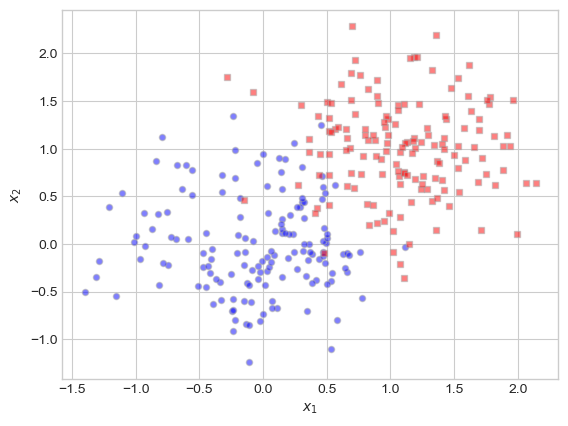

In [7]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_classification_data(X, y, ax):
    targets = [0, 1]
    markers = ["o", "s"]
    colors = ["blue", "red"]
    
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix, 0], X[ix, 1], s=20, c=colors[i], cmap='coolwarm', edgecolors='darkgrey', alpha=0.5, marker=markers[i])
    ax.set(xlabel=r"$x_1$", ylabel=r"$x_2$")

fig, ax = plt.subplots(1, 1)

# p_dims is 2
X, y = classification_data(noise = 0.5)
plot_classification_data(X, y, ax)

Code tp graph a straight line

In [8]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

### Vanilla Gradient Descent

Vanilla gradient descent: When p_dim = 2, when alpha is sufficiently small and beta=0.

Want to see:

1. Gradient descent for logistic regression converges to a weight vector w that looks visually correct
    * show this by plot the decision boundary with the data
2. Loss decreases monotonically: A monotonic function is a function which is either entirely nonincreasing or nondecreasing.
    * show this by plotting the loss over iterations

/var/folders/g2/ybhd80ns31sc72zl62c5qcjm0000gn/T/ipykernel_39193/3274295446.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[ix, 0], X[ix, 1], s=20, c=colors[i], cmap='coolwarm', edgecolors='darkgrey', alpha=0.5, marker=markers[i])


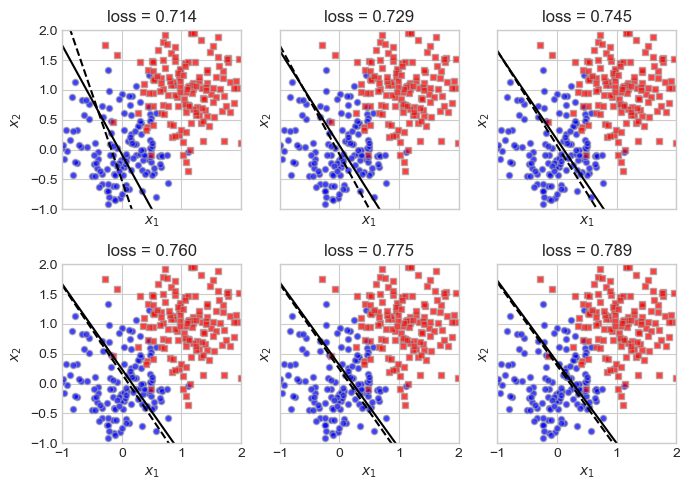

In [59]:
# initialize a Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)
LR.loss(X,y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss_vec = []

for index in range(0, 1000):
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(LR.w)

    # for vanilla gradient descent, alpha must be sufficiently small and beta must be 0
    local_loss = opt.step(X, y, alpha = 0.5, beta = 0)
    
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if (local_loss > 0):
        
        plot_classification_data(X, y, ax)
        
        # Plot and record loss at every iteration
        plot_classification_data(X, y, ax)
        draw_line(old_w, x_min=-1, x_max=2, ax=ax, color="black", linestyle="dashed")
        loss = LR.loss(X, y)
        loss_vec.append(loss)
        draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim=(-1, 2), ylim=(-1, 2))
        
        # Move to the next subplot or break if all subplots are filled
        if(current_ax < 5):
            current_ax += 1
        else:
            break
plt.tight_layout()

Plot the loss over time, only showing when the loss is updated

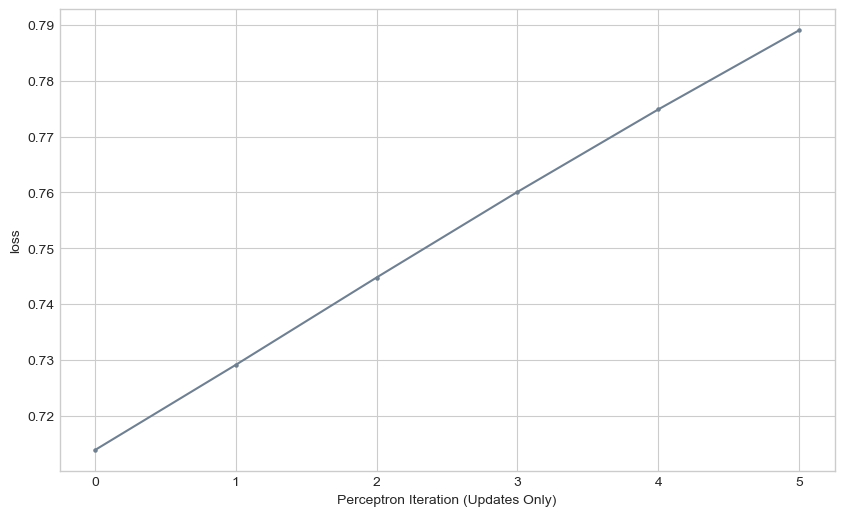

In [60]:
def plot_loss(loss):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))


    plt.plot(loss, color = "slategrey")
    plt.scatter(torch.arange(len(loss)), loss, color = "slategrey", s=5)
    labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

plot_loss(loss_vec)

Through both of these visualizations we can see that the loss is decreasing monotonically over time.

## Benefits of momentum

## Overfitting